In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Load PascalVOC

In [16]:
from tensorflow.python.keras.preprocessing import image
from lxml import etree
from tensorflow.python.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

def getImage(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    return x / 255.

def toGray(im):
    weights = np.array([0.21, 0.72, 0.07])
    im = np.sum(im * weights, axis = -1)
    im = np.array([im, im, im]).transpose(1, 2, 0)
    return im
    
def loadPascalVOC(n_images = 1000):
    images = np.zeros((n_images, 224, 224, 3))
    grays = np.zeros((n_images, 224, 224, 3))
    labels = np.zeros(n_images)
    images_path = "pVOC/VOCdevkit/VOC2012/JPEGImages/"
    labels_path = "pVOC/VOCdevkit/VOC2012/Annotations/"
    
    class_dict = dict(enumerate(['background', 'aeroplane', 'bicycle', 'bird', 'boat',
                                 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
                                 'dog', 'horse', 'motorbike', 'person', 'pottedplant',
                                 'sheep', 'sofa', 'train', 'tvmonitor', 'ambigious']))
    inv_class_dict = {v: k for k, v in class_dict.items()}
    
    for i, path in enumerate(os.listdir(images_path)[:n_images]):
        images[i] = getImage(images_path + path)
        grays[i] = toGray(images[i])
        labels[i] = inv_class_dict[etree.parse(labels_path + path[:-4] + ".xml").xpath("/annotation/object/name")[0].text]
    #images = preprocess_input(images)
    
    n_train = int(.9 * n_images)
    train_images, test_images = images[:n_train], images[n_train:]
    train_grays, test_grays = grays[:n_train], grays[n_train:]
    train_labels, test_labels = labels[:n_train], labels[n_train:]
    
    batch_size = 32
    n_classes = 22
    return train_images, train_labels, train_grays, test_images, test_labels, test_grays, class_dict, batch_size, n_classes

# Preprocess

In [17]:
train_images, train_labels, train_grays, test_images, test_labels, test_grays, class_dict, batch_size, n_classes = loadPascalVOC()

In [18]:
from tensorflow.python.keras.utils import to_categorical

w, h = train_grays.shape[1], train_grays.shape[2]

#Classes
train_labels, test_labels = to_categorical(train_labels), to_categorical(test_labels)

(900, 224, 224, 3) (900, 224, 224, 3)
0.0 1.0 0.0 1.0
(100, 224, 224, 3) (100, 224, 224, 3)
0.0 1.0 0.0 1.0


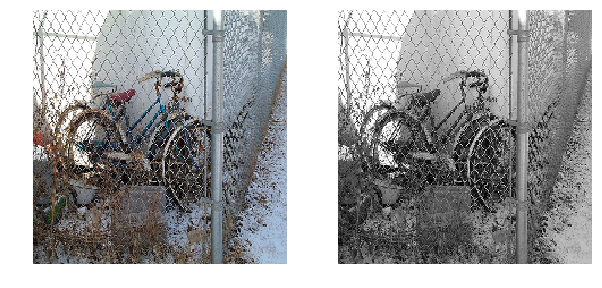

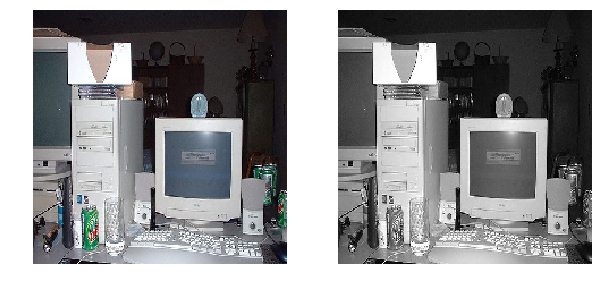

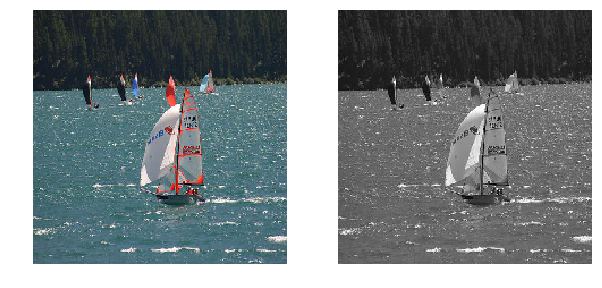

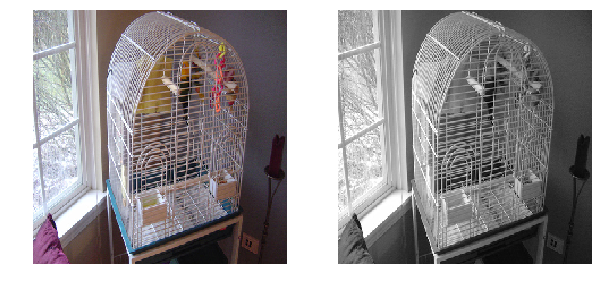

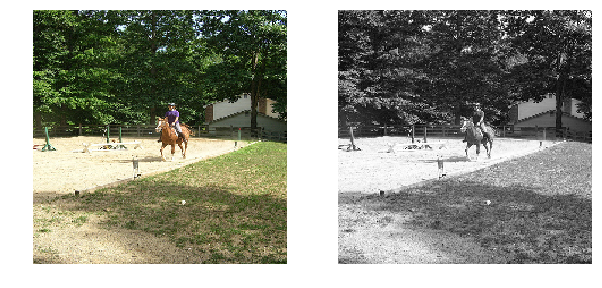

In [19]:
print(train_grays.shape, train_images.shape)
print(np.min(train_grays), np.max(train_grays), np.min(train_images), np.max(train_images))
print(test_grays.shape, test_images.shape)
print(np.min(test_grays), np.max(test_grays), np.min(test_images), np.max(test_images))

for i in range(5):
    plt.figure(figsize = (10, 10))
    ind = np.random.randint(len(test_images))
    plt.subplot(121)
    plt.imshow(test_images[ind])
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(test_grays[ind, :, :, 0], cmap = "gray")
    plt.axis('off')
    plt.show()

# Learning

In [20]:
from tensorflow.python.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

model = ResNet50(weights='imagenet')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [ ]:
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, AveragePooling2D
from tensorflow.python.keras.layers import Concatenate, BatchNormalization, RepeatVector, Flatten, Dense, Reshape


def lowLevelFeatureNetwork(w, h):
    features = Input((w, h, 1), name = "input_features")
    
    conv00 = BatchNormalization()(Conv2D(32, (3, 3), activation='relu', padding = "same")(features))
    conv01 = BatchNormalization()(Conv2D(32, (3, 3), activation='relu', padding = "same")(conv00))
    meanpool0 = AveragePooling2D((2, 2))(conv01)
    
    conv10 = BatchNormalization()(Conv2D(64, (3, 3), activation='relu', padding = "same")(meanpool0))
    conv11 = BatchNormalization()(Conv2D(64, (3, 3), activation='relu', padding = "same")(conv10))
    meanpool1 = AveragePooling2D((2, 2))(conv11)
    
    conv20 = BatchNormalization()(Conv2D(128, (3, 3), activation='relu', padding = "same")(meanpool1))
    conv21 = BatchNormalization()(Conv2D(128, (3, 3), activation='relu', padding = "same")(conv20))
    
    return Model(inputs = features, outputs = conv21, name = "lowLevelFeature")

def midLevelFeatureNetwork(w_, h_):
    features = Input((w_, h_, 128), name = "input_features")
    
    conv00 = BatchNormalization()(Conv2D(128, (3, 3), activation='relu', padding = "same")(features))
    conv01 = BatchNormalization()(Conv2D(128, (3, 3), activation='relu', padding = "same")(conv00))
    
    return Model(inputs = features, outputs = conv01, name = "midLevelFeature")

def colorizationNetwork(w_, h_):
    features = Input((w_, h_, 256), name = "input_features")
    
    conv00 = BatchNormalization()(Conv2D(128, (3, 3), activation='relu', padding = "same")(features))
    conv01 = BatchNormalization()(Conv2D(128, (3, 3), activation='relu', padding = "same")(conv00))
    up0 = UpSampling2D((2, 2))(conv01)
    
    conv10 = BatchNormalization()(Conv2D(64, (3, 3), activation='relu', padding = "same")(up0))
    conv11 = BatchNormalization()(Conv2D(64, (3, 3), activation='relu', padding = "same")(conv10))
    up1 = UpSampling2D((2, 2))(conv11)
    
    conv20 = BatchNormalization()(Conv2D(32, (3, 3), activation='relu', padding = "same")(up1))
    conv21 = BatchNormalization()(Conv2D(32, (3, 3), activation='relu', padding = "same")(conv20))
    
    return Model(inputs = features, outputs = conv21, name = "colorization")

def globalFeatureNetwork(w_, h_):
    features = Input((w_, h_, 128), name = "input_features")
    
    meanpool0 = AveragePooling2D((2, 2))(features)
    
    conv00 = BatchNormalization()(Conv2D(32, (3, 3), activation='relu', padding = "same")(meanpool0))
    conv01 = BatchNormalization()(Conv2D(32, (3, 3), activation='relu', padding = "same")(conv00))
    meanpool1 = AveragePooling2D((2, 2))(conv01)
    
    conv10 = BatchNormalization()(Conv2D(64, (3, 3), activation='relu', padding = "same")(meanpool1))
    conv11 = BatchNormalization()(Conv2D(64, (3, 3), activation='relu', padding = "same")(conv10))
    
    flatten = Flatten()(conv11)

    dense0 = BatchNormalization()(Dense(512, activation = "relu")(flatten))
    dense1 = BatchNormalization()(Dense(256, activation = "relu")(dense0))
    dense2 = BatchNormalization()(Dense(128, activation = "relu")(dense1))
    
    #output = Reshape((w_, h_, -1))(RepeatVector(w_ * h_)(dense2))
    
    return Model(inputs = features, outputs = dense2, name = "globalFeature")

def classificationNetwork(n_classes):
    features = Input((128, ), name = "input_features")
    
    dense0 = BatchNormalization()(Dense(64, activation = "relu")(features))
    dense1 = Dense(n_classes, activation = "softmax")(dense0)
    
    return Model(inputs = features, outputs = dense1, name = "classification")

def build_model(w, h, n_classes):
    nmeanpool = 2
    w_, h_ = w // (2**nmeanpool), h // (2**nmeanpool)
    
    features = Input((w, h, 1), name = "gray_image")
    
    lowLevelFeatures = lowLevelFeatureNetwork(w, h)(features)
    midLevelFeatures = midLevelFeatureNetwork(w_, h_)(lowLevelFeatures)
    
    globalFeatures = globalFeatureNetwork(w_, h_)(lowLevelFeatures)
    
    #Colorization
    chrominance = colorizationNetwork(w_, h_)(Concatenate()([midLevelFeatures,
                                                       Reshape((w_, h_, -1))(RepeatVector(w_ * h_)(globalFeatures))]))
    
    recolored = Conv2D(3, (3, 3), activation='sigmoid',
                       padding = "same", name = "recolor")(Concatenate()([chrominance, features]))
    
    #Classification
    classified = classificationNetwork(n_classes)(globalFeatures)
    
    #Model
    model = Model(inputs = features, outputs = [recolored, classified])
    
    losses = {"recolor" : "mean_squared_error", "classification" : "categorical_crossentropy"}
    lossWeights = {"recolor": 1.0, "classification": 1.0}

    model.compile(optimizer='adadelta', loss = losses, loss_weights = lossWeights, metrics = ["accuracy"])
    
    return model

model = build_model(w, h, n_classes)
model.summary()

In [ ]:
nepochs = 5
history = model.fit(train_grays, {"recolor" : train_images, "classification" : train_labels},
                    epochs=nepochs, batch_size=batch_size,
                    validation_data = (test_grays, {"recolor" : test_images, "classification" : test_labels}))
history_dict = history.history

In [ ]:
plt.figure(figsize = (10, 10))

for i, metric in enumerate(["recolor_loss", "classification_loss", "loss", "classification_acc"]):
    values = history_dict[metric]
    val_values = history_dict['val_' + metric]
    epochs = range(1, len(values) + 1)
    
    plt.subplot(221 + i)
    plt.plot(epochs, values, 'bo', label = 'training ' + metric)
    plt.plot(epochs, val_values, 'b+', label = 'validation ' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.xticks(1 + np.arange(nepochs))
    plt.legend(loc = 'best')
    plt.title('Training and validation ' + metric)
plt.show()

In [ ]:
test_recolored, test_preds = model.predict(test_grays)

for i in range(5):
    ind = np.random.randint(len(test_images))
    plt.subplot(131)
    plt.imshow(test_images[ind])
    plt.title("Original : " + class_dict[np.argmax(test_labels[ind])])
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(test_grays[ind, :, :, 0], cmap = "gray")
    plt.title("Grayscaled")
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(test_recolored[ind])
    plt.title("Colored : " + class_dict[np.argmax(test_preds[ind])])
    plt.axis('off')
    plt.show()